<a href="https://colab.research.google.com/github/Gberlati/health-agent/blob/main/Health_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Health Agent
Un agente para poder conversar con tus estudios médicos.

## Cómo utilizar el agente

Primero, es necesario obtener una API Key para Gemini. Para hacer esto, hay dos métodos:
1. dentro de Google Colab, ir a la sección Secretos, y Hacer click en Gemini API Keys, e importar o crear una Key en Google AI Studio.
2. crear manualmente en Google AI Studio la key, y crear un nuevo secret con clave GEMINI_API_KEY, y de valor la key obtenida.

Luego, crear una carpeta llamada `/data`, donde se van a guardar todos los documentos a utilizar por el Agente.

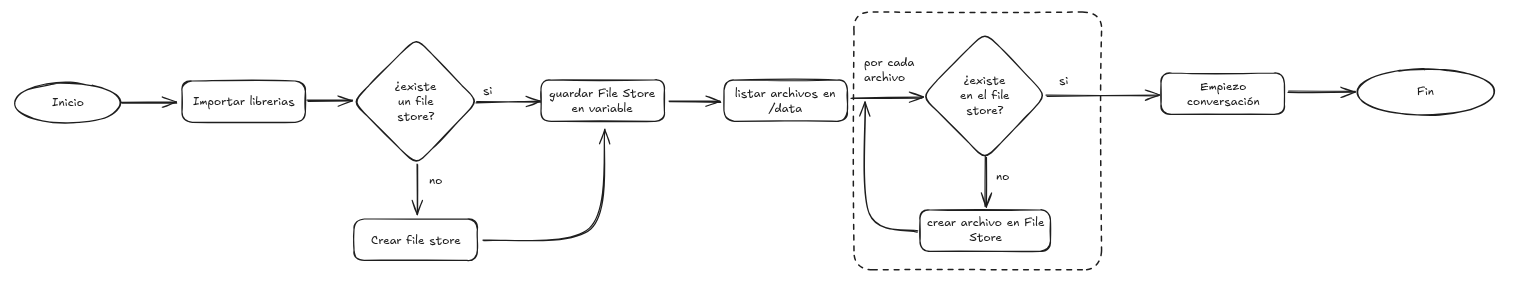

# Preparación de File Store

Importamos las librerías

In [69]:
from google.colab import userdata
from google.genai import types
from google.colab import drive
from pydantic import BaseModel
from google import genai
from pathlib import Path
import time

Instanciamos el cliente de Gemini y definimos el nombre del File Store.


In [70]:
FILE_STORE_NAME = 'health-agent'
client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

Validamos si ya existe el File Store, si no lo creamos.

In [71]:
file_search_store = None

# Buscamos si ya existe el File Store.
stores = client.file_search_stores.list()
for store in stores:
  if store.display_name == FILE_STORE_NAME:
    print(f'Se encontró un File Search Store ya creado.\nName: {store.name}')
    file_search_store = store
    break

# Si no existe, lo creamos
if file_search_store is None:
  print("Se creó un nuevo File Search Store")
  file_search_store = client.file_search_stores.create(config={'display_name': FILE_STORE_NAME})

Se encontró un File Search Store ya creado.
Name: fileSearchStores/healthagent-fx312gnkclwq


Validamos que existan los archivos creados en `/data` dentro del File Search Store.

In [72]:
def load_file_store():
  folder_path = Path('/content/data')

  # Obtenemos los documentos del File Search Store.
  documents = client.file_search_stores.documents.list(parent=file_search_store.name).page

  # Si no existe la carpeta, y no hay documentos, no se puede continuar.
  if not folder_path.is_dir():
    if len(documents) == 0:
      raise FileNotFoundError(f'La carpeta /content/data no fue encontrada, y el file store {file_search_store.name} no tiene documentos creados.\n cree la carpeta y cargue los primeros archivos para continuar.')
    print("No existe la carpeta /content/data, no se crearan nuevos archivos.")
    return

  for file_path in folder_path.iterdir():
    # Validar si es un archivo.
    if not file_path.is_file():
      continue

    # Buscamos si el documento no existe ya en el File Store.
    document = any(doc.display_name == file_path.name for doc in documents)
    if not document:

      # Creamos el documento
      operation = client.file_search_stores.upload_to_file_search_store(
        file=file_path,
        file_search_store_name=file_search_store.name,
        config={
          'display_name' : file_path.name,
        }
      )

      # Esperamos a que termine de importarse el documento
      while not operation.done:
        time.sleep(5)
        operation = client.operations.get(operation)
      print(f'Archivo {file_path.name} creado con éxito.')
    else:
      print(f'El documento {file_path.name} ya existe en el File Store.')

load_file_store()

El documento dami.pdf ya existe en el File Store.
El documento RESULTADOSGB2022 (1).pdf ya existe en el File Store.


# Primer Versión Chat

Definimos el System Prompt

In [73]:
SYSTEM_PROMPT_1 = """
Eres un asistente clínico que responde SIEMPRE en JSON válido UTF-8, sin texto adicional ni markdown.
Debes usar EXACTAMENTE el siguiente esquema de salida en cada turno:

{
  "resumen_breve": "<stri|ng_corto>",
  "hallazgos": [
    {
      "texto": "<pasaje_citable_literal_del_pdf>",
      "fuente": "<archivo#pN>"
    }
  ],
  "explicacion_educativa": [
    "<frase_breve_que_ayude_a_entender_el_significado_clínico_de_lo_anterior>"
  ],
  "red_flags": [
    "<alerta_clínica_relevante_detectada_o_vacío_si_no_hay>"
  ],
  "sugerencias": [
    "<sugerencia_práctica_para_seguimiento/consulta>"
  ],
  "fuentes": [
    { "doc": "<archivo#pN>" }
  ],
  "limitaciones": "<aclaración_de_límites_de_la_respuesta>",
  "disclaimer": "No soy un profesional de la salud. Esta información es solo para ayudarte a organizar tus datos."
}

Reglas estrictas:
- Devuelve SOLO el JSON anterior, sin prólogos, sin 'Respuesta JSON:', sin backticks, sin texto extra.
- Si no hay evidencia en los archivos, devuelve arrays vacíos en 'hallazgos', 'red_flags', 'sugerencias', 'fuentes'; y explica en 'limitaciones' que no encontraste pasajes citables.
- 'hallazgos[].texto' DEBE ser un extracto literal del documento; no lo parafrasees.
- 'hallazgos[].fuente' y 'fuentes[].doc' DEBEN apuntar a los documentos/páginas usados, con formato 'archivo#pN' cuando el paginado esté disponible.
- No inventes valores de laboratorio ni rangos. Si no están explícitos, no los asumas.
- Usa el contexto conversacional previo, pero prioriza SIEMPRE la evidencia de los archivos.
- Mantén respuestas concisas. Máximo 1200 caracteres por campo largo.
"""


In [74]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import re
from typing import List

def to_content(role: str, text: str) -> types.Content:
    return types.Content(
        role=role,
        parts=[types.Part(text=text)]
    )

def old_get_model_response(
    chat_history: List[types.Content  ],
    system_prompt: str,
    store_name: str,
    model_name: str = "gemini-2.5-flash"
) -> str:
    """
    Encapsula la llamada a la API de Gemini, aplicando la instrucción del sistema
    y la herramienta de File Search.
    """
    try:
        response = client.models.generate_content(
            model=model_name,
            contents=chat_history,
            config=types.GenerateContentConfig(
                system_instruction=system_prompt,
                tools=[
                    types.Tool(
                        file_search=types.FileSearch(
                            file_search_store_names=[store_name]
                        )
                    )
                ]
            )
        )
        return response.text
    except Exception as e:
        print(f"Error al llamar al modelo: {e}")
        return "Lo siento, tuve un problema al procesar tu solicitud."

def run_chat_widget(system_prompt: str, store_name: str):
    """
    Inicia y gestiona una sesión de chat interactiva usando ipywidgets.
    """

    # 1. El historial vive dentro del alcance de esta función
    history: List[types.Content] = []

    # 2. Crear los widgets de la UI

    # Área de salida para el chat
    chat_output = widgets.Output(layout={
        'border': '1px solid #ccc',
        'height': '400px',
        'overflow_y': 'auto', # Permite scroll
        'padding': '10px'
    })

    # Campo de texto para la entrada del usuario
    text_input = widgets.Text(
        placeholder="Escribe tu pregunta aquí... ('gracias' para salir)",
        layout={'width': '100%'}
    )

    # Botón de envío
    submit_button = widgets.Button(
        description="Enviar",
        button_style='primary'
    )

    # 3. Definir las funciones "Handler" (manejadoras de eventos)

    def on_submit_clicked(b):
        """
        Se ejecuta cuando se hace clic en el botón "Enviar"
        o se presiona Enter en el campo de texto.
        """
        user_q = text_input.value.strip()

        # Limpiar el campo de texto inmediatamente
        text_input.value = ""

        # Omitir si la entrada está vacía
        if not user_q:
            return

        # Mostrar la pregunta del usuario en el chat_output
        with chat_output:
            print(f"Tú: {user_q}")

        # Cierre por "gracias"
        if re.search(r"\bgracias\b", user_q, flags=re.IGNORECASE):
            with chat_output:
                print("Cierro la conversación. ¡De nada! 👋")
            # Deshabilitar UI para terminar
            text_input.disabled = True
            submit_button.disabled = True
            return

        # --- Lógica de llamada al modelo ---

        # Mostrar estado de "pensando"
        submit_button.description = "Pensando..."
        submit_button.disabled = True

        current_chat_input = history + [to_content("user", user_q)]

        model_response = old_get_model_response(
            chat_history=current_chat_input,
            system_prompt=system_prompt,
            store_name=store_name
        )

        # Restaurar el botón
        submit_button.description = "Enviar"
        submit_button.disabled = False

        # Mostrar respuesta del modelo en el chat_output
        with chat_output:
            print(f"Modelo: {model_response}")

        # --- Actualizar historial ---
        history.append(to_content("user", user_q))
        history.append(to_content("model", model_response))

    # 4. Conectar los Handlers a los eventos de los widgets

    # Conectar el clic del botón
    submit_button.on_click(on_submit_clicked)

    # Conectar la tecla "Enter" en el campo de texto
    text_input.on_submit(on_submit_clicked)

    # 5. Mostrar la UI
    # Organizar widgets en cajas (vertical y horizontal)
    input_box = widgets.HBox([text_input, submit_button])
    ui = widgets.VBox([chat_output, input_box])

    with chat_output:
        print("Iniciando chat... (escribí 'gracias' para terminar)")

    display(ui)

In [75]:
run_chat_widget(system_prompt=SYSTEM_PROMPT_1, store_name=file_search_store.name)

# Segunda versión de Agente

Se construyó una vista con múltiples partes, para integrar la interacción con el agente en una sola interfaz. A continuación, se define cada section, y luego se renderiza el chat.

Utilizando Pydantic, Definimos el structured output esperado en formato JSON del modelo.

In [76]:
import time
from pathlib import Path
from typing import List, Optional
import ipywidgets as widgets
from IPython.display import display, clear_output

In [77]:
SYSTEM_PROMPT_2 = """
Eres un asistente clínico, cuyo objetivo es orientar y ayudar a pacientes a:
 - identificar posibles enfermedades o causas de malestares.
 - obtener un listado de posibles síntomas relacionados a su enfermedad (solo si aplican).
 - recomendar profesionales que puedan guiarlo más en cómo resolver.

Puedes consultar documentos cargados por el paciente como contexto, para comprender mejor su historia clínica.

SOLO si aplica, Añade un breve bloque de Profesionales Recomendados, Posibles Síntomas, y Posible Diagnóstico de enfermedad.
SOLO utiliza texto plano y bullet points. NO utilices **, #, ni ningún markdown.

las respuestas deben ser lo mas concisas, breves y objetivas posible.
"""

## Sección de chat

In [78]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import re
from typing import List

import time
from pathlib import Path
from typing import List, Optional
import ipywidgets as widgets
from IPython.display import display, clear_output

# Import new v1 SDK modules
from google import genai
from google.genai import types
from google.colab import userdata

def get_model_response(
    chat_history: List[types.Content],
    system_prompt: str,
    store_name: str,
    model_name: str = "gemini-2.5-flash"
):
    """
    Encapsula la llamada a la API de Gemini, aplicando la instrucción del sistema
    y la herramienta de File Search.
    """
    try:
        response = client.models.generate_content(
            model=model_name,
            contents=chat_history,
            config=types.GenerateContentConfig(
                system_instruction=SYSTEM_PROMPT_2,
                tools=[
                    types.Tool(
                        file_search=types.FileSearch(
                            file_search_store_names=[store_name]
                        )
                    )
                ],
            )
        )
        return response.text
    except Exception as e:
        print(f"Error al llamar al modelo: {e}")
        return "Lo siento, tuve un problema al procesar tu solicitud."

def to_content(role: str, text: str) -> types.Content:
    return types.Content(
        role=role,
        parts=[types.Part(text=text)]
    )

def create_chat_section(system_prompt: str, store_name: str):
  history: List[types.Content] = []

  # Área de salida para el chat
  chat_output = widgets.Output(layout={
      'border': '1px solid #ccc',
      'height': '200px',  # Adjusted height for the new layout
      'overflow_y': 'auto', # Permite scroll
      'padding': '10px'
  })

  # Campo de texto para la entrada del usuario
  text_input = widgets.Text(
      placeholder="Escribe tu pregunta aquí...",
      layout={'width': '100%'}
  )

  # Botón de envío
  submit_button = widgets.Button(
      description="Enviar",
      button_style='primary'
  )

  def on_submit_clicked(b):
      user_q = text_input.value.strip()
      text_input.value = ""

      if not user_q:
          return

      with chat_output:
          print(f"👤: {user_q}")

      if re.search(r"\bgracias\b", user_q, flags=re.IGNORECASE):
          with chat_output:
              print("Cierro la conversación. ¡De nada! 👋")
          text_input.disabled = True
          submit_button.disabled = True
          return

      submit_button.description = "Pensando..."
      submit_button.disabled = True

      current_chat_input = history + [to_content("user", user_q)]

      model_response = get_model_response(
          chat_history=current_chat_input,
          system_prompt=system_prompt,
          store_name=store_name
      )

      submit_button.description = "Enviar"
      submit_button.disabled = False

      with chat_output:
          print(f"🧑🏻‍⚕️: {model_response}")

      history.append(to_content("user", user_q))
      history.append(to_content("model", model_response))

  submit_button.on_click(on_submit_clicked)
  text_input.on_submit(on_submit_clicked)

  # Organizar widgets en cajas (vertical y horizontal)
  input_box = widgets.HBox([text_input, submit_button])
  chat_section = widgets.VBox(
      [chat_output, input_box],
      layout=widgets.Layout(width='100%', padding='5px')
  )

  with chat_output:
        print("Por favor, valide las respuestas y consulte con especialistas médicos.\n---")

  return chat_section, chat_output # Return chat_output as well

## Sección de recomendaciones y sugerencias

In [79]:
def create_recommendations_section():
  btn_layout = widgets.Layout(width='95%', margin='2px 0 2px 0', border=box_border_style, height='35px')

  sintomas_btn = widgets.Button(description='Síntomas', layout=btn_layout)
  profesionales_btn = widgets.Button(description='Profesionales Recomendados', layout=btn_layout)
  fuentes_btn = widgets.Button(description='Fuentes Utilizadas', layout=btn_layout)

  # Fila de sugerencias
  prev_btn = widgets.Button(icon='arrow-left', layout=widgets.Layout(width='40px'))
  suggestion_label = widgets.Label(
      'Sugerencia 1',
      layout=widgets.Layout(display='flex', justify_content='center', flex='1', border=box_border_style, padding='0 5px')
  )
  next_btn = widgets.Button(icon='arrow-right', layout=widgets.Layout(width='40px'))

  suggestions_hbox = widgets.HBox(
      [prev_btn, suggestion_label, next_btn],
      layout=widgets.Layout(width='95%', margin='10px 0 0 0', justify_content='space-between')
  )

  recommendations_section = widgets.VBox(
      [sintomas_btn, profesionales_btn, fuentes_btn, suggestions_hbox],
      layout=widgets.Layout(width='40%', align_items='center', padding='5px')
  )

  return recommendations_section

## Sección de Fuentes de datos

In [80]:
# Helper function to list documents
def list_store_documents():
    return client.file_search_stores.documents.list(parent=file_search_store.name).page

# Global container for the fuentes section to allow dynamic updates
fuentes_section_container = widgets.VBox()

def _update_fuentes_section_display(chat_output):
    """Updates the content of the fuentes_section_container."""
    fuentes_section_container.children = [] # Clear existing children

    fuentes_title = widgets.Label(
        'Fuentes disponibles',
        layout=widgets.Layout(align_self='center', font_weight='bold')
    )

    store_display_name = file_search_store.name.split('/')[-1]
    fuentes_subtitle = widgets.Label(
        f'(Conectado a {store_display_name})',
        layout=widgets.Layout(align_self='center', margin='0 0 10px 0')
    )

    docs = list_store_documents()
    source_rows = []
    if docs:
        for doc in docs:
            # FIX: Use lambda to pass chat_output to the callback implicitly
            source_rows.append(create_source_row(doc, lambda: _update_fuentes_section_display(chat_output)))
    else:
        source_rows.append(widgets.Label('No hay documentos cargados en el File Store.'))

    # Botones inferiores
    eliminar_todos_btn = widgets.Button(description='Eliminar Todos')
    buscar_btn = widgets.Button(description='Buscar /data')

    # Handlers for bottom buttons
    def on_delete_all_clicked(b):
        for doc in list_store_documents():
            client.file_search_stores.documents.delete(name=doc.name, config={"force": True})
        _update_fuentes_section_display(chat_output)

    def on_buscar_data_clicked(b):
        load_file_store()
        _update_fuentes_section_display(chat_output)

    eliminar_todos_btn.on_click(on_delete_all_clicked)
    buscar_btn.on_click(on_buscar_data_clicked)

    bottom_buttons_hbox = widgets.HBox(
        [eliminar_todos_btn, buscar_btn],
        layout=widgets.Layout(justify_content='center', margin='10px 0 5px 0')
    )

    fuentes_section_container.children = [fuentes_title, fuentes_subtitle] + source_rows + [bottom_buttons_hbox]
    fuentes_section_container.layout = widgets.Layout(
        border=box_border_style,
        width='99%',
        margin='10px 0 0 0',
        padding='10px',
        align_items='center'
    )

# Function auxiliary to create a source row
def create_source_row(doc, refresh_callback):
    # doc is now the actual document object
    display_name = doc.display_name
    size_bytes = doc.size_bytes
    mime_type = doc.mime_type
    create_time = doc.create_time

    size_kb = round(size_bytes / 1024) if size_bytes else 'N/A'
    formatted_date = create_time.strftime('%d/%m/%Y') if create_time else 'N/A'
    file_extension = mime_type.split('/')[-1] if mime_type else display_name.split('.')[-1] if '.' in display_name else 'N/A'

    description = f"{display_name} | {size_kb}kb | .{file_extension} | {formatted_date}"
    label = widgets.Label(description, layout=widgets.Layout(flex='1'))
    button = widgets.Button(description='Eliminar')

    def on_delete_clicked(b):
        client.file_search_stores.documents.delete(name=doc.name, config={"force": True})
        refresh_callback() # Call the refresh function after deletion

    button.on_click(on_delete_clicked)

    return widgets.HBox(
        [label, button],
        layout=widgets.Layout(
            border=box_border_style,
            width='98%',
            padding='5px',
            margin='2px 0',
            align_items='center'
        )
    )

# The original create_fuentes_section will now just return the container and trigger the update.
def create_fuentes_section(chat_output_widget):
    _update_fuentes_section_display(chat_output_widget) # Initial population
    return fuentes_section_container

# Health Agent Final

In [81]:
import ipywidgets as widgets
from IPython.display import display

# --- Definir Layouts para Estilos ---
# Usamos Layout para simular los bordes y tamaños del wireframe
box_border_style = 'solid 1px #888'
item_layout = widgets.Layout(width='auto') # Layout base para items

# Create chat section and get chat_output
chat_section, chat_output = create_chat_section(SYSTEM_PROMPT_2, file_search_store.name)

# --- Contenedor Principal Superior (Izquierda + Derecha) ---
main_section = widgets.HBox(
    [chat_section],
    layout=widgets.Layout(border=box_border_style, width='99%', padding='5px')
)

# Call create_fuentes_section to get the populated container, passing chat_output
fuentes_section_widget = create_fuentes_section(chat_output)

# --- 5. Layout Final de la Aplicación ---
app_layout = widgets.VBox(
    [main_section, fuentes_section_widget],
    layout=widgets.Layout(
        border='solid 2px black',
        width='100%',
        padding='10px',
        display='flex',
        flex_flow='column',
        align_items='stretch'
    )
)

# --- Mostrar la Interfaz ---
display(app_layout)

# Versión con errores

In [82]:
import time
import re
import traceback # Importante para ver errores detallados
from typing import List, Optional
import ipywidgets as widgets
from IPython.display import display, clear_output

from google import genai
from google.genai import types
from pydantic import BaseModel, Field

# --- 1. Modelos Pydantic (Igual que antes) ---
class Hallazgo(BaseModel):
    texto: str = Field(description="Cita literal del documento")
    fuente: str = Field(description="Nombre del archivo y página si aplica")

class ProfesionalRecomendado(BaseModel):
    rubro: str = Field(description="Especialidad médica (ej: Cardiología)")
    razon: str = Field(description="Por qué se recomienda este especialista")

class HealthAgentResponse(BaseModel):
    resumen_breve: str = Field(description="Respuesta conversacional directa y empática al usuario")
    hallazgos: List[Hallazgo] = Field(description="Evidencia encontrada en los documentos. Vacío si no hay.")
    red_flags: List[str] = Field(description="Alertas clínicas graves detectadas (o vacío)")
    sugerencias: List[str] = Field(description="Pasos a seguir o recomendaciones de estilo de vida")
    profesionales_recomendados: List[ProfesionalRecomendado] = Field(description="Especialistas sugeridos")
    limitaciones: str = Field(description="Aclaración si falta información en los documentos")

SYSTEM_PROMPT = """
Eres un asistente clínico llamado "Health Agent".
Analiza documentos médicos y UNICAMENTE responde en JSON.
"""

# --- 2. Lógica del Modelo con LOGS ---

def test_get_model_response(chat_history, system_prompt, store_name, model_name="gemini-2.5-flash"):
    print("\n--- [DEBUG] Inicio de llamada al modelo ---")
    print(chat_history)
    # 1. Validar Store Name
    print(f"[DEBUG] Store Name recibido: '{store_name}' (Tipo: {type(store_name)})")
    if not store_name:
        print("[ERROR CRÍTICO] El store_name está vacío. Esto causará el error de tools.")
        return None

    # 2. Construir Tools explícitamente para inspección
    try:
        my_tool = types.Tool(
            file_search=types.FileSearch(
                file_search_store_names=[store_name]
            )
        )
        print(f"[DEBUG] Tool construida: {my_tool}")
    except Exception as e:
        print(f"[ERROR CRÍTICO] Fallo al construir el objeto Tool: {e}")
        return None

    # 3. Llamada a la API
    try:
        print(f"[DEBUG] Enviando solicitud a {model_name} con {len(chat_history)} mensajes previos...")

        response = client.models.generate_content(
            model=model_name,
            contents=chat_history,
            config={
                "system_instruction": system_prompt,
                "tools": [my_tool],
                "response_mime_type": "application/json",
                "response_json_schema": HealthAgentResponse.model_json_schema()
            }
        )

        print("[DEBUG] Respuesta cruda recibida del modelo.")
        print(f"[DEBUG] Texto respuesta: {response.text[:100]}...") # Descomentar si se quiere ver el JSON raw

        #parsed_response = HealthAgentResponse.model_validate_json(response.parsed)
        print("[DEBUG] JSON parseado exitosamente con Pydantic.")
        return response.text

    except Exception as e:
        print(f"\n[ERROR API] Ocurrió una excepción durante generate_content:")
        print(f"Mensaje: {str(e)}")
        # Imprimir traceback completo para ver donde falla exactamente
        traceback.print_exc()
        return None

# --- 3. UI Class con Logs de Interacción ---

class HealthAgentUI:
    def __init__(self, system_prompt, store_name):
        print(f"[UI INIT] Inicializando UI con store: {store_name}")
        self.system_prompt = system_prompt
        self.store_name = store_name
        self.history = []
        self.current_data: Optional[HealthAgentResponse] = None
        self.suggestion_index = 0

        # Estilos
        self.box_border = '1px solid #ccc'
        self.layout_btn = widgets.Layout(width='98%', margin='2px', height='35px')

        self._init_chat_widgets()
        self._init_recommendation_widgets()
        self._init_fuentes_widgets()
        self.ui = self._build_layout()

    def _init_chat_widgets(self):
        self.chat_output = widgets.Output(layout={'border': self.box_border, 'height': '300px', 'overflow_y': 'scroll', 'padding': '10px'})
        self.text_input = widgets.Text(placeholder="Escribe tu consulta...", layout={'width': '80%'})
        self.submit_btn = widgets.Button(description="Enviar", button_style='primary', layout={'width': '18%'})

        self.submit_btn.on_click(self.on_submit)
        self.text_input.on_submit(self.on_submit)

    def _init_recommendation_widgets(self):
        self.btn_sintomas = widgets.Button(description='Ver Red Flags', layout=self.layout_btn, disabled=True)
        self.btn_profesionales = widgets.Button(description='Profesionales', layout=self.layout_btn, disabled=True)
        self.btn_hallazgos = widgets.Button(description='Ver Hallazgos', layout=self.layout_btn, disabled=True)

        self.btn_sintomas.on_click(lambda b: self.print_details("red_flags"))
        self.btn_profesionales.on_click(lambda b: self.print_details("profesionales"))
        self.btn_hallazgos.on_click(lambda b: self.print_details("hallazgos"))

        self.btn_prev = widgets.Button(icon='arrow-left', layout=widgets.Layout(width='40px'))
        self.btn_next = widgets.Button(icon='arrow-right', layout=widgets.Layout(width='40px'))
        self.lbl_sugerencia = widgets.Label(value='Esperando análisis...', layout=widgets.Layout(display='flex', justify_content='center', flex='1', border=self.box_border, padding='5px'))

        self.btn_prev.on_click(self.prev_suggestion)
        self.btn_next.on_click(self.next_suggestion)

    def _init_fuentes_widgets(self):
        self.fuentes_output = widgets.VBox(layout={'border': self.box_border, 'padding': '10px', 'margin': '10px 0'})
        # Intentar listar documentos al inicio
        try:
            print(f"[UI] Listando documentos del store {self.store_name}...")
            # Nota: Asegúrate de que client esté definido globalmente
            docs = client.file_search_stores.documents.list(parent=self.store_name).page
            count = len(list(docs)) if docs else 0
            print(f"[UI] Documentos encontrados: {count}")
            self.fuentes_output.children = [widgets.Label(f"📚 Conectado a Data Store ({count} docs)")]
        except Exception as e:
            print(f"[UI WARNING] No se pudo listar documentos: {e}")
            self.fuentes_output.children = [widgets.Label("Error conectando al Data Store")]

    def _build_layout(self):
        input_box = widgets.HBox([self.text_input, self.submit_btn], layout={'width': '100%'})
        left_panel = widgets.VBox([self.chat_output, input_box], layout=widgets.Layout(width='60%', padding='5px'))
        nav_box = widgets.HBox([self.btn_prev, self.lbl_sugerencia, self.btn_next], layout={'width': '98%', 'justify_content': 'space-between'})
        right_panel = widgets.VBox([widgets.HTML("<b>Panel de Control</b>"), self.btn_sintomas, self.btn_profesionales, self.btn_hallazgos, widgets.HTML("<br><b>Sugerencias:</b>"), nav_box], layout=widgets.Layout(width='40%', padding='5px', border=self.box_border))
        return widgets.VBox([widgets.HBox([left_panel, right_panel]), self.fuentes_output])

    def on_submit(self, _):
        user_q = self.text_input.value.strip()
        if not user_q: return

        self.text_input.value = ""
        self.submit_btn.disabled = True
        self.submit_btn.description = "Pensando..."

        with self.chat_output:
            print(f"👤: {user_q}")

        self.history.append(types.Content(role="user", parts=[types.Part(text=user_q)]))

        # Llamada debug
        response_obj = test_get_model_response(self.history, self.system_prompt, self.store_name)

        if response_obj:
            self.current_data = response_obj
            self.history.append(types.Content(role="model", parts=[types.Part(text=response_obj.resumen_breve)]))
            with self.chat_output:
                print(f"🤖: {response_obj.resumen_breve}")
            self.update_right_panel(response_obj)
        else:
            with self.chat_output:
                print("⚠️ Error obteniendo respuesta (Revisa los logs en la consola)")

        self.submit_btn.disabled = False
        self.submit_btn.description = "Enviar"

    def update_right_panel(self, data):
        print(f"[UI] Actualizando panel derecho. Flags: {len(data.red_flags)}, Profs: {len(data.profesionales_recomendados)}")
        self.btn_sintomas.disabled = not (data.red_flags)
        self.btn_profesionales.disabled = not (data.profesionales_recomendados)
        self.btn_hallazgos.disabled = not (data.hallazgos)
        self.suggestion_index = 0
        self.update_suggestion_label()

    def update_suggestion_label(self):
        if not self.current_data or not self.current_data.sugerencias:
            self.lbl_sugerencia.value = "Sin sugerencias"
            return
        idx = self.suggestion_index
        total = len(self.current_data.sugerencias)
        self.lbl_sugerencia.value = f"({idx + 1}/{total}) {self.current_data.sugerencias[idx]}"

    def next_suggestion(self, _):
        if self.current_data and self.current_data.sugerencias:
            self.suggestion_index = (self.suggestion_index + 1) % len(self.current_data.sugerencias)
            self.update_suggestion_label()

    def prev_suggestion(self, _):
        if self.current_data and self.current_data.sugerencias:
            self.suggestion_index = (self.suggestion_index - 1) % len(self.current_data.sugerencias)
            self.update_suggestion_label()

    def print_details(self, category):
        if not self.current_data: return
        with self.chat_output:
            print(f"\n--- {category.upper()} ---")
            if category == "red_flags":
                for x in self.current_data.red_flags: print(f"🔴 {x}")
            elif category == "profesionales":
                for x in self.current_data.profesionales_recomendados: print(f"👨‍⚕️ {x.rubro}: {x.razon}")
            elif category == "hallazgos":
                for x in self.current_data.hallazgos: print(f"📄 {x.texto} (Fuente: {x.fuente})")
            print("-" * 20)

# --- EJECUCIÓN ---

# 1. Imprime qué Store Name estamos usando para asegurar que no sea None
current_store_name = file_search_store.name
print(f"Nombre del Data Store activo: '{current_store_name}'")

if not current_store_name:
    print("🚨 ALERTA: El nombre del store está vacío. El código fallará.")
else:
    # 2. Iniciar App
    app = HealthAgentUI(SYSTEM_PROMPT_2, current_store_name)
    display(app.ui)

Nombre del Data Store activo: 'fileSearchStores/healthagent-fx312gnkclwq'
[UI INIT] Inicializando UI con store: fileSearchStores/healthagent-fx312gnkclwq
[UI] Listando documentos del store fileSearchStores/healthagent-fx312gnkclwq...
[UI] Documentos encontrados: 2
